# DSCI 100 Group Project Proposal

team: Rachel Liang, Ziyan He, Yuchen Zhang, Zohane Bal

In [15]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


### Introduction    

The dataset we are working on is downloaded from the UCI Machine Learning Repository. Although the dataset contains four databases about the heart disease diagnosis from 4 different locations, we only picked the database collected from the Cleveland Clinic Foundation since it is the only data base that has full 14 attributes recored for each heart disease diagnosis. The total instances in this database is 303.

### Load Data and Wrangle Data
This dataset does not need to be cleaned since it does not have any missing data or missing attributes. <br>
We added column names to the dataset and selected columns we needed for analysis. Also as we are treating some attributes's numeric values as categorical variables, we used as.factor() for conversion.

In [33]:
heart_disease_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"


heart_disease_data <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                        mutate(cp = as.factor(cp), fbs = as.factor(fbs), restecg = as.factor(restecg), 
                               exang = as.factor(exang), slope = as.factor(slope), sex = as.factor(sex)) %>% 
                        select(age, sex, cp, chol, fbs, slope, num)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



### 14 Attributes Description
* Age: age in years
* Sex: ( 1 = male, 0 = female)
* Cp: chest pain type
Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4 asymptomatic
* Trestbps: Resting Blood pressure ( in mm Hg on admission to hospital)
* Chol: Serum cholesterol in mg/dl
* Fbs: Fastig blood suger > 120 (1 = true, 0 = false)
* Dm: 1 = history if diabetes , 0 = no such history)
* Restecg: Resting electro cardiac results
Value 0 : normal
Value 1: having ST-T wave abnormality ( T wave inversion and/or ST elevation or depression of > 0.05 mV)
Value 2” Showing probable or definite left ventricular hypertrophy by Estes’ criteria
* Thalach: maximum heart rate achieved
* Exang: exercise induced angina (1 = yes ,0 = no)
* Oldpeak:ST depression induced by exercise relative to rest
* Slope: The slope of the peak exercise ST segment
Value 1: upsloping
Value 2: flat
Value 3: downsloping
* Ca: Number of major vessels (0-3) coloured by fluorosopy
* Thal: 3 = normal , 6= fixed defect , 7 = reversible defect
* Num: diagnosis of heart disease
Value 0 <50% diameter narrowing
Value 1 > 50% Diameter narrowing

### Split Into Training and Testing Dataset
Based on the number of instances in this dataset, we decided that setting 75% of the data in the dataset as training data and the remaining 25% as testing data will make a good balance for training the classifier and evaluating the classifier's accuracy.

In [34]:
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

head(heart_disease_data, 10)

age,sex,cp,chol,fbs,slope,num
<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
63,1,1,233,1,3,0
67,1,4,286,0,2,2
67,1,4,229,0,2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,354,0,1,0
63,1,4,254,0,2,2
53,1,4,203,1,3,1


### Summary

In [35]:
summary(heart_disease_train)

      age        sex     cp           chol     fbs     slope        num        
 Min.   :29.00   0: 75   1: 19   Min.   :126   0:191   1:109   Min.   :0.0000  
 1st Qu.:47.00   1:154   2: 35   1st Qu.:209   1: 38   2:104   1st Qu.:0.0000  
 Median :55.00           3: 62   Median :239           3: 16   Median :0.0000  
 Mean   :54.14           4:113   Mean   :245                   Mean   :0.9782  
 3rd Qu.:60.00                   3rd Qu.:270                   3rd Qu.:2.0000  
 Max.   :77.00                   Max.   :564                   Max.   :4.0000  

### Visualization


The boxplot below shows the distribution of age for each different probability level of having a heart disease.

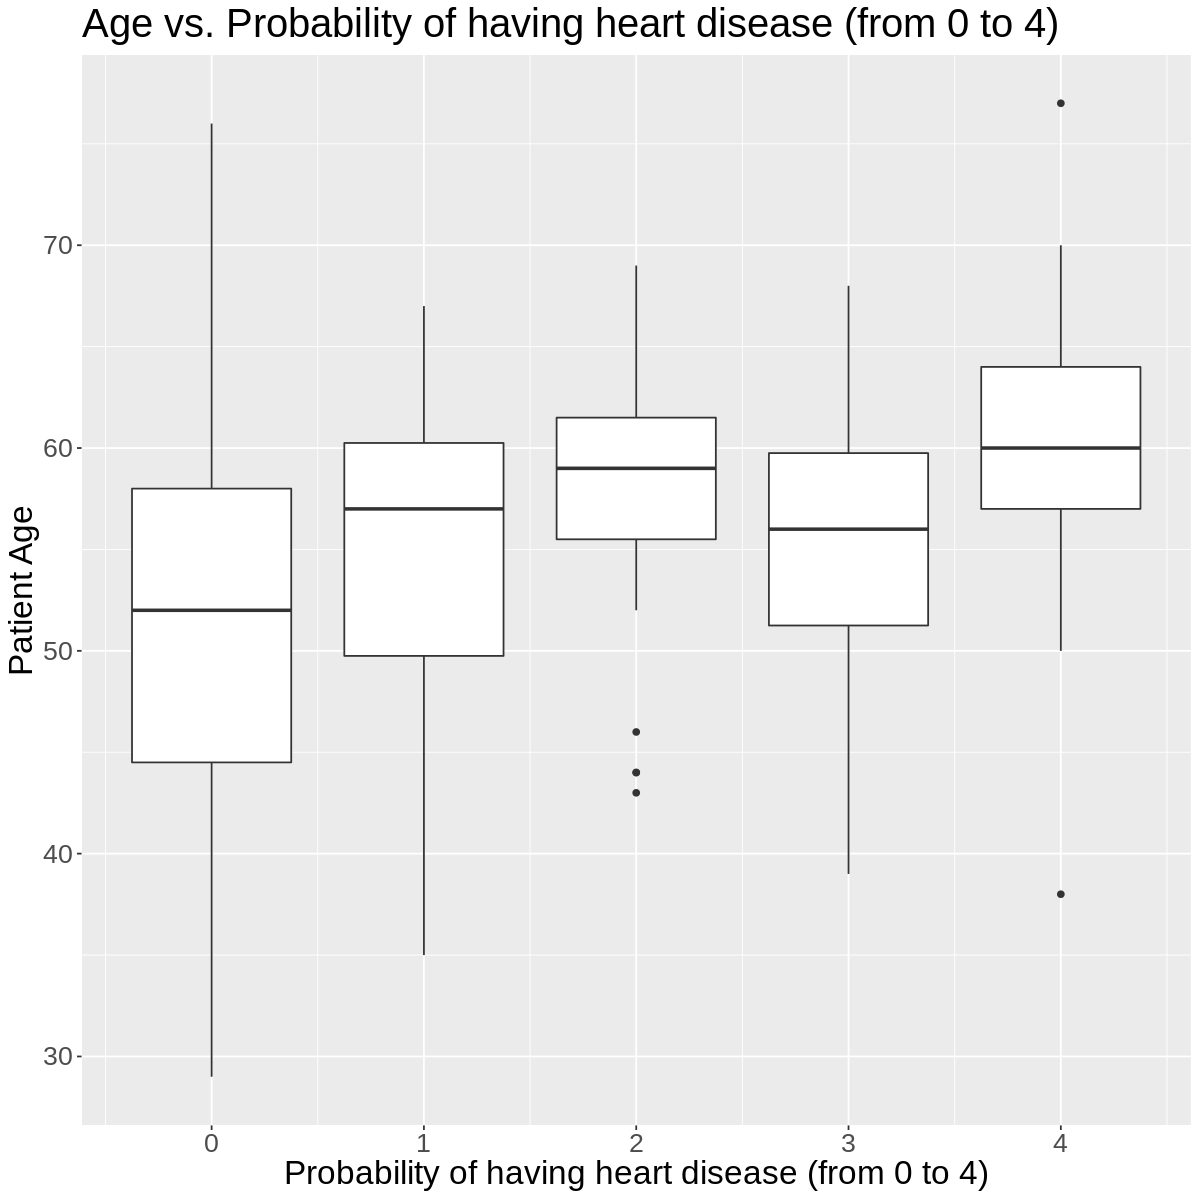

In [36]:
age_vs_heart_disease <- heart_disease_train %>% 
                    ggplot(aes(x = num, y = age)) +
                    geom_boxplot(aes(group = num)) +
                    labs(x = "Probability of having heart disease (from 0 to 4)", y = "Patient Age") +
                    ggtitle("Age vs. Probability of having heart disease (from 0 to 4)") +
                    theme(text = element_text(size = 20))
                    
age_vs_heart_disease

The graph2 below shows the distribution of different chest pain types for different probability levels of having heart disease.<br>
Chest pain type 1-4 means:
* Value 1: typical angina
* Value 2: atypical angina
* Value 3: non-anginal pain
* Value 4: asymptomatic
<br>


`summarise()` regrouping output by 'num' (override with `.groups` argument)



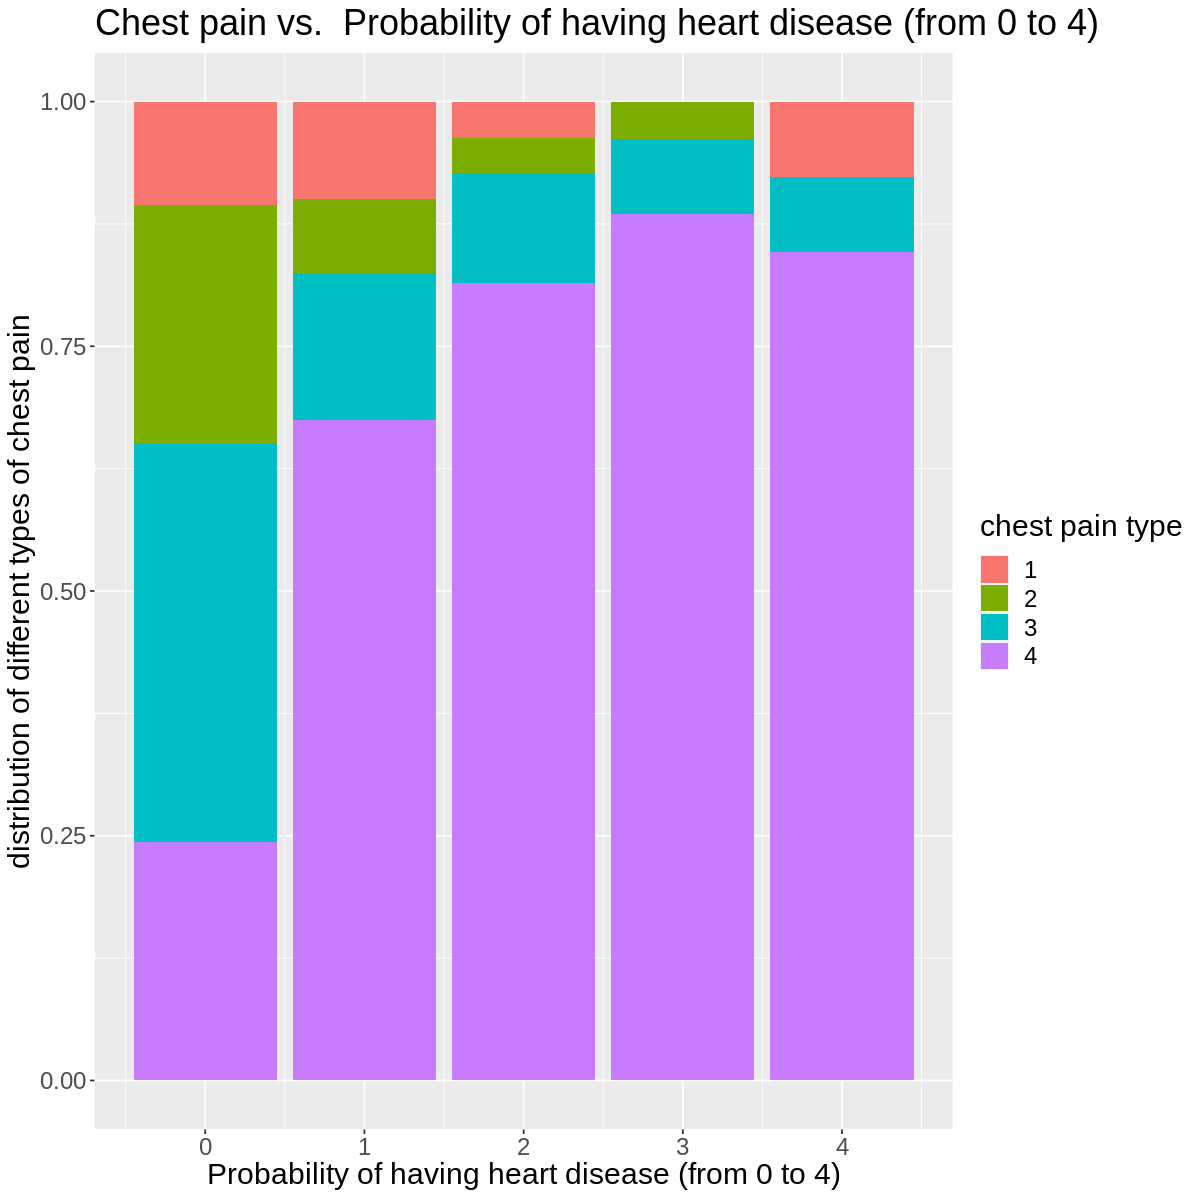

In [37]:
options(repr.plot.width = 10, repr.plot.height = 10) 

sex_vs_heart_disease <- heart_disease_train %>% 
                        select(num, cp) %>% 
                        group_by(num, cp) %>% 
                        summarize(n = n()) %>% 
                        ggplot(aes(x = num, y = n, fill = cp)) +
                        geom_bar(stat = "identity",position = "fill") +
                        labs(x =  "Probability of having heart disease (from 0 to 4)", y = "distribution of different types of chest pain", fill = "chest pain type") +
                        ggtitle("Chest pain vs.  Probability of having heart disease (from 0 to 4)") +
                        theme(text = element_text(size = 18))
sex_vs_heart_disease

### Method

In order to make the prediction, there are three steps to do:
1. Create a k-nn model specification and a recipe for the fit method.
2. Train the model with the training dataset to build the classifier.
3. Use the classifier to predict the labels in the test sets.       

#### 6 Predictors chosen:
* age, sex, chest pain types (cp), serum cholestoral in mg/dl (chol), fasting blood sugar level (fbs), the slope of the peak exercise ST segment(slope)




### Expected Outcomes and Significance    

1. What do you expect to find?   

    Our training dataset will allow us to predict the probability of an individual contracting heart disease given patient's . 
    Additionally, we hope to discover which factors are most associated with a person's risk of developing a heart disease.  

2. What impact could such findings have?    

    With this finding, doctors would be able to analyze patients’ records in a more informative manner. It will be easier to make a swift decision to conduct further diagnostic cardiology on the patient if a certain index is abnormal as indicated in the report later, and this will significantly reduce the chance of misdiagnosis and provide more time for patient diagnosis and treatment.  

3. What future questions could this lead to?   

    As this dataset only has 303 instances which is not sufficient for making accurate predictions, we could increase the accuracy of prediction by including more instances . Furthermore, since this data set only contains patients’ data in Cleveland, it would also be interesting to observe if the key factors leading to heart disease differ between different locations if we have a heart disease data set from a collection of locations. 
